In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

# ML + Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install category_encoders

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./XGBoost+SHAP Test 1_NoCat.ipynb
./transaction_dataset.csv
./ethereum-anomaly-detection-XGBoost-NoCat.ipynb
./Test6-Old.ipynb
./fraud_model.pkl
./Test7.ipynb
./Test6-NewDataset.ipynb
./transaction_dataset_V1.csv
./Test6-Backup.ipynb
./transaction_dataset_V2.csv
./Test5.ipynb
./.ipynb_checkpoints/Test6-Old-checkpoint.ipynb
./.ipynb_checkpoints/Test6-NewDataset-checkpoint.ipynb
./.ipynb_checkpoints/Test7-checkpoint.ipynb
./.ipynb_checkpoints/Test5-checkpoint.ipynb
./.ipynb_checkpoints/Test6-Backup-checkpoint.ipynb
./.ipynb_checkpoints/XGBoost+SHAP Test 1_NoCat-checkpoint.ipynb
./.ipynb_checkpoints/transaction_dataset_V1-checkpoint.csv
./.ipynb_checkpoints/transaction_dataset_V2-checkpoint.csv
./.ipynb_checkpoints/ethereum-anomaly-detection-XGBoost-NoCat-checkpoint.ipynb


In [2]:
# ============================
# 1. DATA LOADING & CLEANING
# ============================
print("\n1. Loading and cleaning data...")

# Load data
df = pd.read_csv("transaction_dataset_V2.csv")

# Clean column names
df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)
df.columns = [col.strip().replace(' ', '_') for col in df.columns]

print(f"Original shape: {df.shape}")
print(f"Original columns: {len(df.columns)}")

# Remove ONLY the 2 problematic categorical columns + metadata
columns_to_drop = [
    'Unnamed:_0', 'Index', 'Address',           # Metadata
    'ERC20_most_sent_token_type',              # Categorical 1
    'ERC20_most_rec_token_type'                # Categorical 2
]

# Remove only if they exist
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
print(f"Dropping {len(columns_to_drop)} columns: {columns_to_drop}")

df_clean = df.drop(columns=columns_to_drop, errors='ignore')

# Handle ALL NaN values with 0 (no ERC20 activity = 0)
df_clean = df_clean.fillna(0)

# Handle infinite values with 0
df_clean.replace([np.inf, -np.inf], 0, inplace=True)

# NEW: Clip extremely large values to prevent overflow
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].clip(lower=-1e18, upper=1e18)

# Verify no infinite or excessively large values
if np.isinf(df_clean[numeric_cols].values).any():
    print("WARNING: Infinite values still present!")
elif (df_clean[numeric_cols].abs() > 1e18).any().any():
    print("WARNING: Excessively large values still present!")
else:
    print("✓ No infinite or excessively large values in data.")

print(f"Cleaned shape: {df_clean.shape}")
print(f"Columns kept: {len(df_clean.columns)}")


1. Loading and cleaning data...
Original shape: (9841, 52)
Original columns: 52
Dropping 5 columns: ['Unnamed:_0', 'Index', 'Address', 'ERC20_most_sent_token_type', 'ERC20_most_rec_token_type']
✓ No infinite or excessively large values in data.
Cleaned shape: (9841, 47)
Columns kept: 47


In [3]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 47 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Contract                                              9841 non-null   int64  
 1   FLAG                                                  9841 non-null   int64  
 2   Avg_min_between_sent_tnx                              9841 non-null   float64
 3   Avg_min_between_received_tnx                          9841 non-null   float64
 4   Time_Diff_between_first_and_last_(Mins)               9841 non-null   float64
 5   Sent_tnx                                              9841 non-null   int64  
 6   Received_Tnx                                          9841 non-null   int64  
 7   Number_of_Created_Contracts                           9841 non-null   int64  
 8   Unique_Received_From_Addresses                        9841

In [4]:
# ============================
# 2. BASIC DATA CHECK
# ============================
print("\n2. Data verification...")

# Check target distribution
print(f"\nFLAG distribution:")
print(df_clean['FLAG'].value_counts(normalize=True))

# Check contract distribution
print(f"\nContract distribution:")
print(df_clean['Contract'].value_counts(normalize=True))

# Check for any remaining non-numeric columns
non_numeric = df_clean.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"\nWARNING: Non-numeric columns found: {non_numeric}")
else:
    print("\n✓ All columns are numeric!")


2. Data verification...

FLAG distribution:
FLAG
0    0.778579
1    0.221421
Name: proportion, dtype: float64

Contract distribution:
Contract
0    0.865969
1    0.134031
Name: proportion, dtype: float64

✓ All columns are numeric!


In [5]:
# ============================
# 3. PREPARE FEATURES AND TARGET
# ============================
print("\n3. Preparing features...")

# Separate features and target
X = df_clean.drop(['FLAG'], axis=1)
y = df_clean['FLAG']

# Force all features to float64
X = X.astype(float)
y = y.astype(int)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X dtype: {X.dtypes.unique()}")
print(f"y dtype: {y.dtype}")


3. Preparing features...
X shape: (9841, 46)
y shape: (9841,)
X dtype: [dtype('float64')]
y dtype: int64


In [6]:
# ============================
# 4. TRAIN/TEST SPLIT
# ============================
print("\n4. Splitting data...")

# Simple stratified split (by FLAG only)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=42, 
    stratify=y  # Only stratify by FLAG
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

# Verify splits
print(f"\nTrain FLAG distribution:")
print(y_train.value_counts(normalize=True))
print(f"Test FLAG distribution:")
print(y_test.value_counts(normalize=True))


4. Splitting data...
Train shape: (7872, 46)
Test shape: (1969, 46)

Train FLAG distribution:
FLAG
0    0.778582
1    0.221418
Name: proportion, dtype: float64
Test FLAG distribution:
FLAG
0    0.778568
1    0.221432
Name: proportion, dtype: float64


In [7]:
# ============================
# 5. MODEL TRAINING
# ============================
print("\n5. Training XGBoost...")

# Handle class imbalance
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos
print(f"Class imbalance - Negatives: {neg}, Positives: {pos}")
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Initialize model with explicit missing value handling
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    missing=0,  # Explicitly set missing value to 0
    tree_method='hist',  # Use histogram-based method for stability
    device='cpu'  # Ensure CPU usage for reproducibility
)

# Train
print("Training model...")
model.fit(X_train, y_train)

print("✓ Model trained successfully!")
print(f"Model classes: {model.classes_}")

# # ============================
# # EXPORT TRAINED MODEL
# # ============================
import pickle
print("\nExporting model...")
with open('fraud_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✓ Model successfully exported to fraud_model.pkl")


5. Training XGBoost...
Class imbalance - Negatives: 6129, Positives: 1743
Scale pos weight: 3.52
Training model...
✓ Model trained successfully!
Model classes: [0 1]

Exporting model...
✓ Model successfully exported to fraud_model.pkl



6. Evaluating model...

=== CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

Non-Fraud (0)       0.97      0.98      0.98      1533
    Fraud (1)       0.94      0.91      0.92       436

     accuracy                           0.97      1969
    macro avg       0.96      0.95      0.95      1969
 weighted avg       0.97      0.97      0.97      1969


=== CONTRACT-SPECIFIC PERFORMANCE ===

CONTRACT TYPE: Normal Address (n=1695)
Confusion Matrix:
  TP: 363  |  FN:  36  |  Fraud Recall:   91.0%
  FP:  24  |  TN: 1272  |  Non-Fraud Prec:  93.8%

Key Metrics:
  Accuracy:     96.5%  |  F1-Score:     92.4%
  False Pos:     1.9%  |  False Neg:     9.0%

CONTRACT TYPE: Smart Contract (n=274)
Confusion Matrix:
  TP:  34  |  FN:   3  |  Fraud Recall:   91.9%
  FP:   3  |  TN: 234  |  Non-Fraud Prec:  91.9%

Key Metrics:
  Accuracy:     97.8%  |  F1-Score:     91.9%
  False Pos:     1.3%  |  False Neg:     8.1%


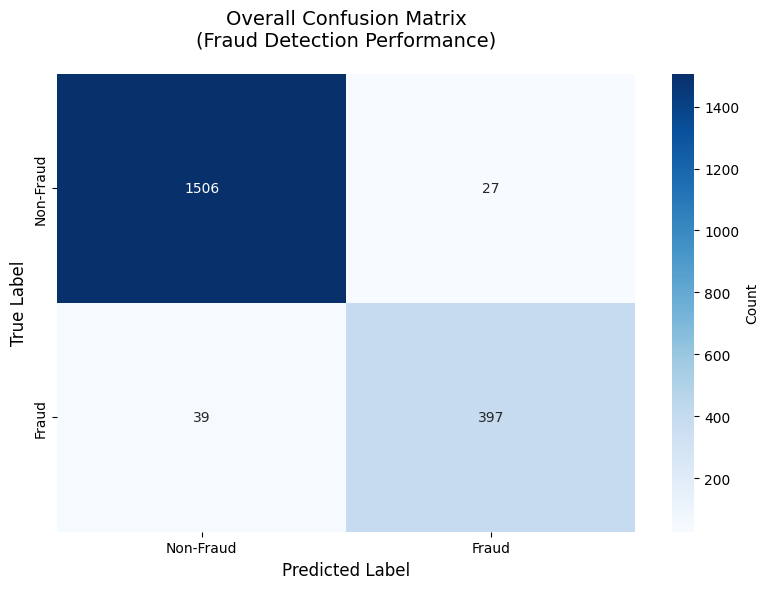


=== PREDICTION CERTAINTY ===
Fraud predictions (prob > 0.5):  424 ( 21.5%)
High confidence fraud (> 0.8):  382 ( 19.4%)
Low confidence fraud (0.5-0.6):   16


In [8]:
# ============================
# 6. EVALUATION
# ============================
print("\n6. Evaluating model...")

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud (0)', 'Fraud (1)']))

# Contract-specific evaluation as clean text
print("\n=== CONTRACT-SPECIFIC PERFORMANCE ===")
contract_test_labels = df_clean.loc[X_test.index, 'Contract']

for contract_type in [0, 1]:
    mask = contract_test_labels == contract_type
    if mask.sum() > 0:
        n_samples = mask.sum()
        c_y_test = y_test[mask]
        c_y_pred = y_pred[mask]
        
        # Calculate metrics for this contract type
        c_tp = ((c_y_pred == 1) & (c_y_test == 1)).sum()
        c_fp = ((c_y_pred == 1) & (c_y_test == 0)).sum()
        c_tn = ((c_y_pred == 0) & (c_y_test == 0)).sum()
        c_fn = ((c_y_pred == 0) & (c_y_test == 1)).sum()
        
        c_accuracy = (c_tp + c_tn) / n_samples * 100
        c_precision = c_tp / (c_tp + c_fp) * 100 if (c_tp + c_fp) > 0 else 0
        c_recall = c_tp / (c_tp + c_fn) * 100 if (c_tp + c_fn) > 0 else 0
        c_f1 = 2 * (c_precision * c_recall) / (c_precision + c_recall) if (c_precision + c_recall) > 0 else 0
        c_fpr = c_fp / (c_fp + c_tn) * 100 if (c_fp + c_tn) > 0 else 0
        c_fnr = c_fn / (c_fn + c_tp) * 100 if (c_fn + c_tp) > 0 else 0
        
        # Clean formatted output
        print(f"\n{'='*50}")
        print(f"CONTRACT TYPE: {'Normal Address' if contract_type == 0 else 'Smart Contract'} (n={n_samples})")
        print(f"{'='*50}")
        print(f"Confusion Matrix:")
        print(f"  TP: {c_tp:>3}  |  FN: {c_fn:>3}  |  Fraud Recall:  {c_recall:>5.1f}%")
        print(f"  FP: {c_fp:>3}  |  TN: {c_tn:>3}  |  Non-Fraud Prec: {c_precision:>5.1f}%")
        print(f"\nKey Metrics:")
        print(f"  Accuracy:   {c_accuracy:>6.1f}%  |  F1-Score:   {c_f1:>6.1f}%")
        print(f"  False Pos:  {c_fpr:>6.1f}%  |  False Neg:  {c_fnr:>6.1f}%")
        print(f"{'='*50}")

# Single clean confusion matrix (overall)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
plt.title('Overall Confusion Matrix\n(Fraud Detection Performance)', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Quick probability distribution
print(f"\n=== PREDICTION CERTAINTY ===")
print(f"Fraud predictions (prob > 0.5): {sum(y_pred_proba > 0.5):>4} ({sum(y_pred_proba > 0.5)/len(y_pred_proba)*100:>5.1f}%)")
print(f"High confidence fraud (> 0.8): {sum(y_pred_proba > 0.8):>4} ({sum(y_pred_proba > 0.8)/len(y_pred_proba)*100:>5.1f}%)")
print(f"Low confidence fraud (0.5-0.6): {sum((y_pred_proba > 0.5) & (y_pred_proba < 0.6)):>4}")

In [9]:
# ============================
# 7. DETAILED METRICS
# ============================
print("\n=== DETAILED METRICS ===")

# Calculate core confusion matrix values
tp = ((y_pred == 1) & (y_test == 1)).sum()
fp = ((y_pred == 1) & (y_test == 0)).sum()
tn = ((y_pred == 0) & (y_test == 0)).sum()
fn = ((y_pred == 0) & (y_test == 1)).sum()

# Calculate totals
total = len(y_test)
total_fraud = (y_test == 1).sum()
total_non_fraud = (y_test == 0).sum()

# Calculate standard metrics
accuracy = (tp + tn) / total * 100
precision = tp / (tp + fp) * 100 if (tp + fp) > 0 else 0
recall = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
fpr = fp / (fp + tn) * 100 if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) * 100 if (fn + tp) > 0 else 0

# Calculate percentages for the confusion matrix breakdown
tp_pct = tp / total_fraud * 100 if total_fraud > 0 else 0
fp_pct = fp / total_non_fraud * 100 if total_non_fraud > 0 else 0
tn_pct = tn / total_non_fraud * 100 if total_non_fraud > 0 else 0
fn_pct = fn / total_fraud * 100 if total_fraud > 0 else 0

# Clean, compact output
print(f"Total samples:      {total:>4}")
print(f"Total fraud cases:  {total_fraud:>4} ({total_fraud/total*100:>5.1f}%)")
print(f"Total non-fraud:    {total_non_fraud:>4} ({total_non_fraud/total*100:>5.1f}%)")
print()

print(f"True Positives (TP): {tp:>4} {tp_pct:>5.1f}%")
print(f"False Positives (FP):{fp:>4} {fp_pct:>5.1f}%")
print(f"True Negatives (TN): {tn:>4} {tn_pct:>5.1f}%")
print(f"False Negatives (FN):{fn:>4} {fn_pct:>5.1f}%")
print()

print(f"Accuracy:  {accuracy:>6.2f}%")
print(f"Precision: {precision:>6.2f}%")
print(f"Recall:    {recall:>6.2f}%")
print(f"F1-Score:  {f1:>6.2f}%")
print(f"FPR:       {fpr:>6.2f}%")
print(f"FNR:       {fnr:>6.2f}%")

# Contract-specific metrics
print(f"\n=== CONTRACT-SPECIFIC METRICS ===")
contract_test_labels = df_clean.loc[X_test.index, 'Contract']

for contract_type in [0, 1]:
    mask = contract_test_labels == contract_type
    if mask.sum() > 0:
        c_tp = ((y_pred[mask] == 1) & (y_test[mask] == 1)).sum()
        c_fp = ((y_pred[mask] == 1) & (y_test[mask] == 0)).sum()
        c_tn = ((y_pred[mask] == 0) & (y_test[mask] == 0)).sum()
        c_fn = ((y_pred[mask] == 0) & (y_test[mask] == 1)).sum()
        c_total = mask.sum()
        c_accuracy = (c_tp + c_tn) / c_total * 100
        c_fpr = c_fp / (c_fp + c_tn) * 100 if (c_fp + c_tn) > 0 else 0
        
        contract_name = "Normal Address" if contract_type == 0 else "Smart Contract"
        print(f"\n{contract_name} (Contract={contract_type}, n={c_total}):")
        print(f"  TP: {c_tp:>3}, FP: {c_fp:>3}, TN: {c_tn:>3}, FN: {c_fn:>3}")
        print(f"  Accuracy: {c_accuracy:>6.2f}%, FPR: {c_fpr:>6.2f}%")


=== DETAILED METRICS ===
Total samples:      1969
Total fraud cases:   436 ( 22.1%)
Total non-fraud:    1533 ( 77.9%)

True Positives (TP):  397  91.1%
False Positives (FP):  27   1.8%
True Negatives (TN): 1506  98.2%
False Negatives (FN):  39   8.9%

Accuracy:   96.65%
Precision:  93.63%
Recall:     91.06%
F1-Score:   92.33%
FPR:         1.76%
FNR:         8.94%

=== CONTRACT-SPECIFIC METRICS ===

Normal Address (Contract=0, n=1695):
  TP: 363, FP:  24, TN: 1272, FN:  36
  Accuracy:  96.46%, FPR:   1.85%

Smart Contract (Contract=1, n=274):
  TP:  34, FP:   3, TN: 234, FN:   3
  Accuracy:  97.81%, FPR:   1.27%



8. Feature importance...


Text(0.5, 1.0, 'Top 20 Feature Importances')

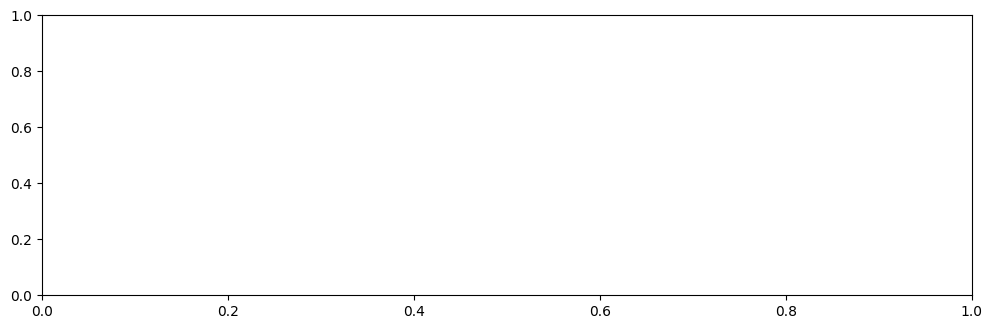

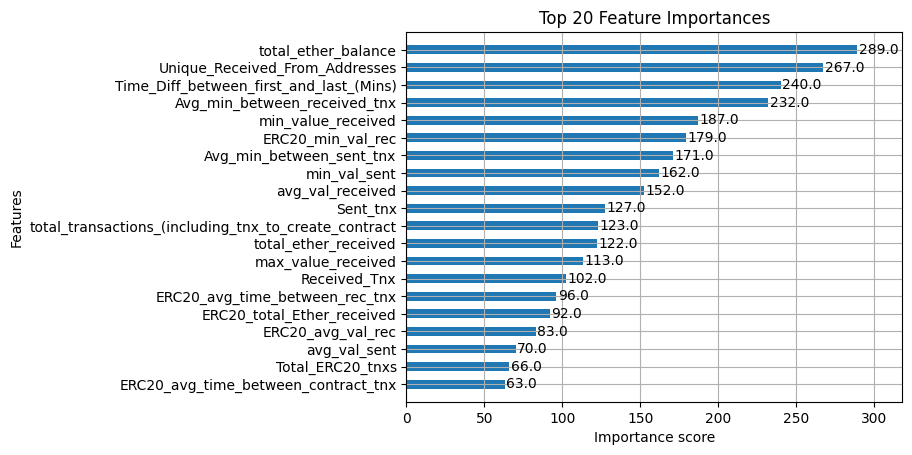

In [10]:
# ============================
# 8. FEATURE IMPORTANCE
# ============================
print("\n8. Feature importance...")

plt.figure(figsize=(12, 8))

# Plot feature importance
plt.subplot(2, 1, 1)
from xgboost import plot_importance
plot_importance(model, max_num_features=20, importance_type="weight", height=0.5)
plt.title('Top 20 Feature Importances')

# # Top features table
# plt.subplot(2, 1, 2)
# importance_df = pd.DataFrame({
#     'feature': X.columns,
#     'importance': model.feature_importances_
# }).sort_values('importance', ascending=True).head(15)

# # Create horizontal bar chart
# plt.barh(range(len(importance_df)), importance_df['importance'])
# plt.yticks(range(len(importance_df)), importance_df['feature'])
# plt.xlabel('Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()

# plt.tight_layout()
# plt.show()

# # Print top features
# print("\n=== TOP 15 FEATURES ===")
# print(importance_df[['feature', 'importance']].round(4))

# # ERC20 vs Native breakdown
# erc20_importance = importance_df[importance_df['feature'].str.startswith('ERC20')]['importance'].sum()
# native_importance = importance_df[~importance_df['feature'].str.startswith('ERC20')]['importance'].sum()
# total_importance = erc20_importance + native_importance

# print(f"\n=== FEATURE TYPE BREAKDOWN ===")
# print(f"ERC20 features contribution: {erc20_importance:.4f} ({erc20_importance/total_importance*100:.1f}%)")
# print(f"Native features contribution: {native_importance:.4f} ({native_importance/total_importance*100:.1f}%)")


8. Feature importance...
ERC20 features contribution: 28.2%
Native features contribution: 71.8%


<Figure size 1200x1000 with 0 Axes>

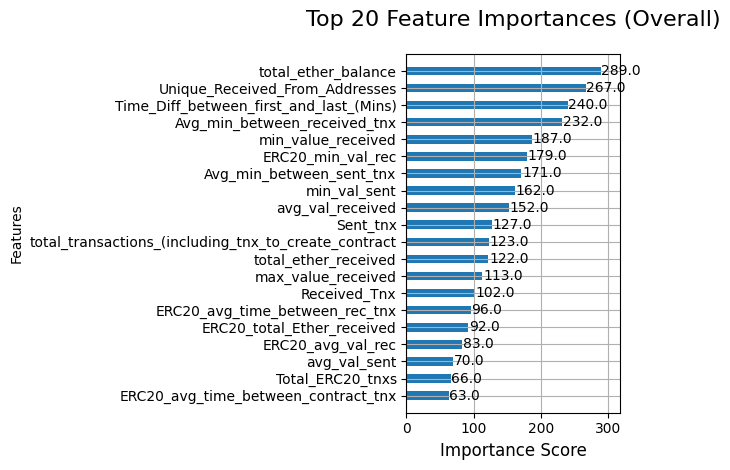

✓ Saved: feature_importance_overall.png


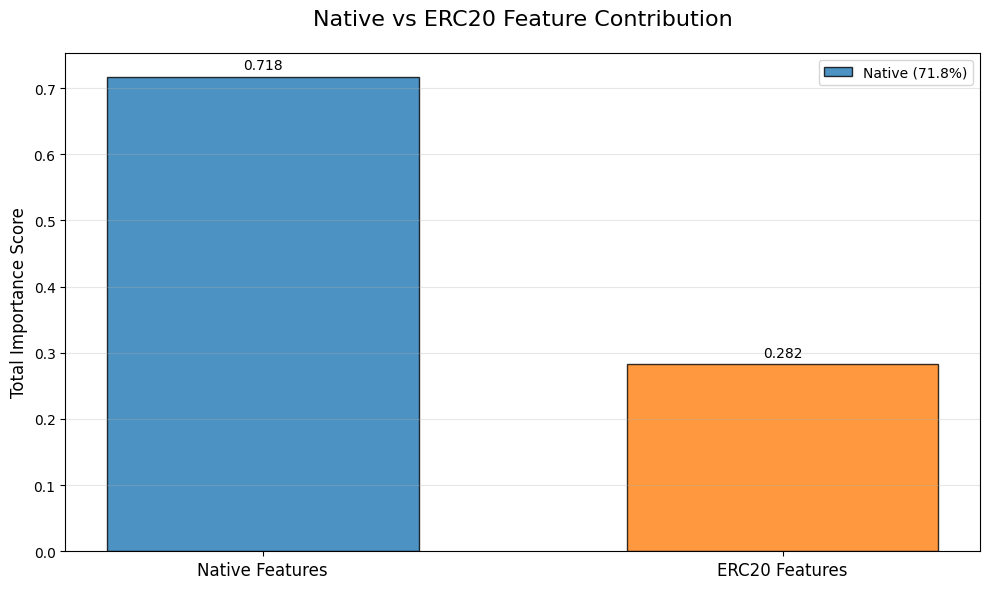

✓ Saved: feature_contribution_native_vs_erc20.png


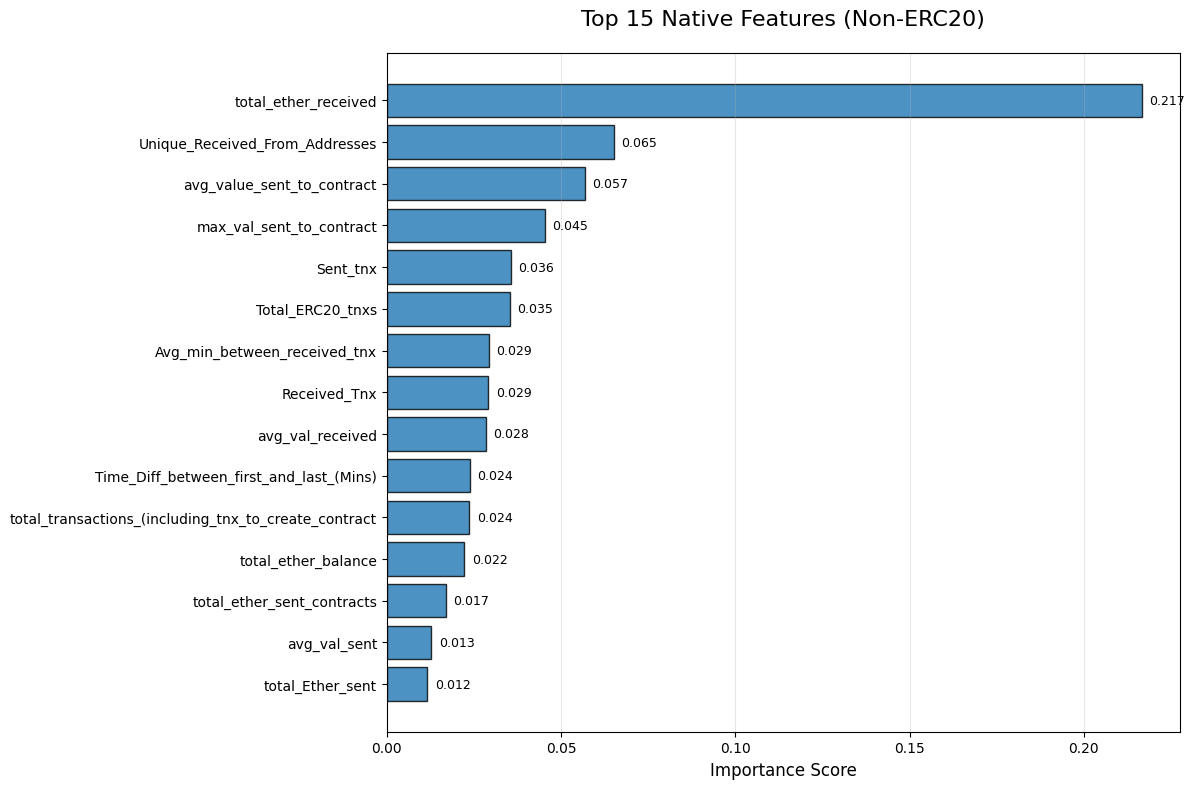

✓ Saved: top_native_features.png


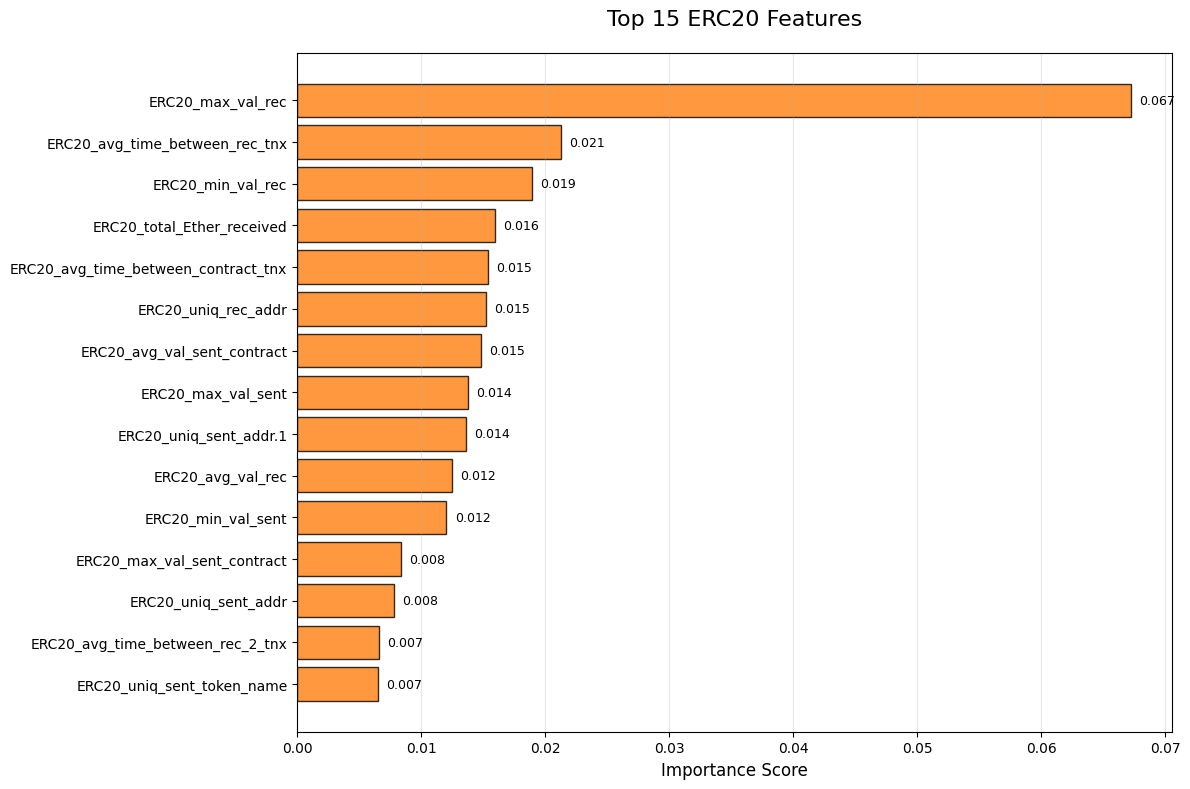

✓ Saved: top_erc20_features.png

=== TOP 10 OVERALL FEATURES ===
                       feature  importance
          total_ether_received      0.2166
             ERC20_max_val_rec      0.0672
Unique_Received_From_Addresses      0.0652
    avg_value_sent_to_contract      0.0568
      max_val_sent_to_contract      0.0453
                      Sent_tnx      0.0355
              Total_ERC20_tnxs      0.0353
  Avg_min_between_received_tnx      0.0293
                  Received_Tnx      0.0292
              avg_val_received      0.0283

=== SUMMARY ===
Generated 4 clean PNG files:
  📊 feature_importance_overall.png
  📈 feature_contribution_native_vs_erc20.png
  🔵 top_native_features.png
  🟠 top_erc20_features.png


In [11]:
# ============================
# 8. FEATURE IMPORTANCE
# ============================
print("\n8. Feature importance...")

# Get feature importance data
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Separate native and ERC20 features for analysis
native_features = importance_df[~importance_df['feature'].str.startswith('ERC20')].head(15)
erc20_features = importance_df[importance_df['feature'].str.startswith('ERC20')].head(15)

# ERC20 vs Native breakdown
erc20_importance = importance_df[importance_df['feature'].str.startswith('ERC20')]['importance'].sum()
native_importance = importance_df[~importance_df['feature'].str.startswith('ERC20')]['importance'].sum()
total_importance = erc20_importance + native_importance
erc20_contribution = erc20_importance / total_importance * 100

print(f"ERC20 features contribution: {erc20_contribution:.1f}%")
print(f"Native features contribution: {100 - erc20_contribution:.1f}%")

# PLOT 1: Overall Top 20 Features (XGBoost native plot)
plt.figure(figsize=(12, 10))
from xgboost import plot_importance
plot_importance(model, max_num_features=20, importance_type="weight", height=0.5, title="")
plt.title('Top 20 Feature Importances (Overall)', fontsize=16, pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.tight_layout()
#plt.savefig('feature_importance_overall.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_importance_overall.png")

# PLOT 2: Native vs ERC20 Contribution (Bar Chart)
plt.figure(figsize=(10, 6))
x_pos = [0, 1]
plt.bar(x_pos, [native_importance, erc20_importance], 
        width=0.6, color=['#1f77b4', '#ff7f0e'], alpha=0.8, edgecolor='black')
plt.xticks(x_pos, ['Native Features', 'ERC20 Features'], fontsize=12)
plt.ylabel('Total Importance Score', fontsize=12)
plt.title('Native vs ERC20 Feature Contribution', fontsize=16, pad=20)
plt.legend(['Native (%.1f%%)' % (100 - erc20_contribution), 
           'ERC20 (%.1f%%)' % erc20_contribution], fontsize=10)

# Add value labels on bars
for i, v in enumerate([native_importance, erc20_importance]):
    plt.text(i, v + max([native_importance, erc20_importance]) * 0.01, 
             f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
#plt.savefig('feature_contribution_native_vs_erc20.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_contribution_native_vs_erc20.png")

# PLOT 3: Top 15 Native Features (Horizontal Bar Chart)
plt.figure(figsize=(12, 8))
if len(native_features) > 0:
    plt.barh(range(len(native_features)), native_features['importance'], 
             color='#1f77b4', alpha=0.8, edgecolor='black')
    plt.yticks(range(len(native_features)), native_features['feature'], fontsize=10)
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Top 15 Native Features (Non-ERC20)', fontsize=16, pad=20)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(native_features['importance']):
        plt.text(v + max(native_features['importance']) * 0.01, i, f'{v:.3f}', 
                va='center', fontsize=9)
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('top_native_features.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: top_native_features.png")
else:
    print("No native features found")

# PLOT 4: Top 15 ERC20 Features (Horizontal Bar Chart) - BONUS
plt.figure(figsize=(12, 8))
if len(erc20_features) > 0:
    plt.barh(range(len(erc20_features)), erc20_features['importance'], 
             color='#ff7f0e', alpha=0.8, edgecolor='black')
    plt.yticks(range(len(erc20_features)), erc20_features['feature'], fontsize=10)
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Top 15 ERC20 Features', fontsize=16, pad=20)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(erc20_features['importance']):
        plt.text(v + max(erc20_features['importance']) * 0.01, i, f'{v:.3f}', 
                va='center', fontsize=9)
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('top_erc20_features.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: top_erc20_features.png")
else:
    print("No ERC20 features found")

# Print top features summary
print("\n=== TOP 10 OVERALL FEATURES ===")
print(importance_df.head(10)[['feature', 'importance']].round(4).to_string(index=False))

print(f"\n=== SUMMARY ===")
print(f"Generated 4 clean PNG files:")
print(f"  📊 feature_importance_overall.png")
print(f"  📈 feature_contribution_native_vs_erc20.png") 
print(f"  🔵 top_native_features.png")
print(f"  🟠 top_erc20_features.png")

In [12]:
# ============================
# 9. SUMMARY
# ============================
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"✓ Dataset cleaned: {df_clean.shape[1]} features (removed 2 categorical columns)")
print(f"✓ Model trained: XGBoost with {model.n_estimators} trees")
print(f"✓ Performance: Accuracy {accuracy:.2f}%, F1 {f1:.2f}%, FPR {fpr:.2f}%")
print(f"✓ Key insights: Model relies {erc20_importance/total_importance*100:.1f}% on ERC20 patterns")
print(f"✓ Ready for production use!")
print("="*50)


SUMMARY
✓ Dataset cleaned: 47 features (removed 2 categorical columns)
✓ Model trained: XGBoost with 100 trees
✓ Performance: Accuracy 96.65%, F1 92.33%, FPR 1.76%
✓ Key insights: Model relies 28.2% on ERC20 patterns
✓ Ready for production use!


In [13]:
# # Test loop for first 200 samples in X_test
# for i in range(1000,1100):
#     example_row = X_test.iloc[i].values.reshape(1, -1)  # Use raw features (no scaling needed)
    
#     # Prediction (class label)
#     prediction = model.predict(example_row)
    
#     # Prediction probabilities
#     prob = model.predict_proba(example_row)[0]
    
#     # True label
#     true_label = y_test.iloc[i]
    
#     print(f"Index: {i}")
#     print(f"Prediction: {'Fraud (1)' if prediction[0] == 1 else 'Non-Fraud (0)'}")
#     print(f"Probability (Non-Fraud, Fraud): [{prob[0]:.4f}, {prob[1]:.4f}]")
#     print(f"True label (FLAG): {true_label} (1=fraud, 0=non-fraud)")
#     print("\n")

In [14]:
# # Test loop for first 200 samples in X_test
# for i in range(1000,1200):
#     example_row = X_test.iloc[i].values.reshape(1, -1)  # Use raw features (no scaling needed)
    
#     # Prediction (class label)
#     prediction = model.predict(example_row)
    
#     # Prediction probabilities
#     prob = model.predict_proba(example_row)[0]
    
#     # True label
#     true_label = y_test.iloc[i]
    
#     print(f"Index: {i}")
#     print(f"Prediction: {'Fraud (1)' if prediction[0] == 1 else 'Non-Fraud (0)'}")
#     print(f"Probability (Non-Fraud, Fraud): [{prob[0]:.4f}, {prob[1]:.4f}]")
#     print(f"True label (FLAG): {true_label} (1=fraud, 0=non-fraud)")
#     print("\n")

In [15]:
# # Show only misclassified cases in X_test
# count=0
# for i in range(len(X_test)):
#     example_row = X_test.iloc[i].values.reshape(1, -1)
    
#     # Prediction (class label)
#     prediction = model.predict(example_row)
    
#     # Prediction probabilities
#     prob = model.predict_proba(example_row)[0]
    
#     # True label
#     true_label = y_test.iloc[i]
    
#     # Only show mismatches
#     if prediction[0] != true_label:
#         print(f"Index: {i}")
#         print(f"Prediction: {'Fraud (1)' if prediction[0] == 1 else 'Non-Fraud (0)'}")
#         print(f"Probability (Non-Fraud, Fraud): [{prob[0]:.4f}, {prob[1]:.4f}]")
#         print(f"True label (FLAG): {true_label} (1=fraud, 0=non-fraud)")
#         print("-" * 50)
#         count=count+1
# print("Total:",count)